# La transformation vmap

In [1]:
import jax.numpy as jnp
import jax
from jax import grad, jit, vmap
from jax import random as jr
import matplotlib.pyplot as plt
import numpy as np

## qu'est-ce qu'une transformation

'Transformation' c'est le terme pour une fonction qui prend en entrée une fonction et return une autre fonction.

In [2]:
def fn_of_x_to_fn_of_2x(fn):

fn_of_x = lambda x: x**2
fn_of_2x = fn_of_x_to_fn_of_2x(fn_of_x)
fn_of_2x(3)

In [2]:
#--- To keep following outputs, do not run this cell! ---

36

Le décorateur `@`: une autre manière d'appliquer une transformation

In [3]:
@fn_of_x_to_fn_of_2x
def fn(x):
    return x**2

fn(3)

***A vous:*** Sur le plot ci-dessous, qui est `fn_of_x`, qui est `fn_of_2x`. Faites votre propre raisonnement pour ne jamais vous tromper.


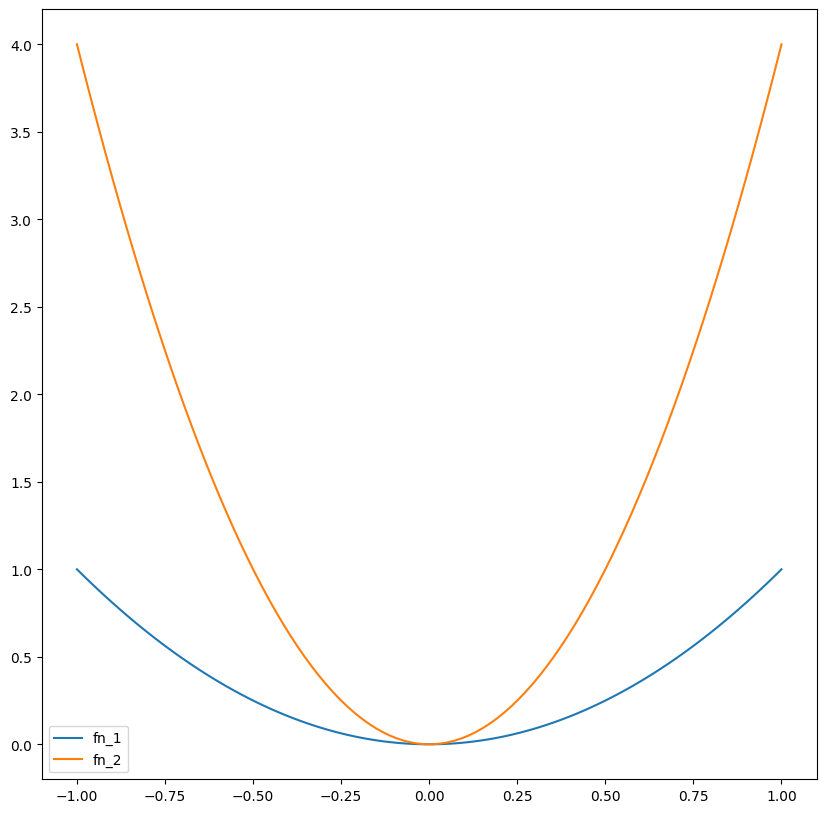

In [4]:
#--- To keep following outputs, do not run this cell! ---

## vmap sur tous les arguments

In [5]:
def fn_of_x_y(x,y):
    return x[0]*y[0]+x[0]*y[1]+x[1]*y[0]

x=jnp.array([1,2])
y=jnp.array([3,4])
fn_of_x_y(x,y)

In [6]:
fn_of_xV_yV = vmap(fn_of_x_y)

batch_size = 7
xV = jnp.ones([batch_size,2])
yV = jnp.ones([batch_size,2])



## En précisant les arguments


Tout à l'heure:

    fn_of_xV_yV = vmap(fn_of_x_y)

Etait l'équivalent de

    fn_of_xV_yV = vmap(fn_of_x_y,[0,0])


Souvent, on veut vmaper que sur un seul argument

In [7]:
def U_of_θ_inp(θ,inp):
    return θ[0] + θ[1]*inp

θ = jnp.array([1.,2])
inp_dim = 2
inp = jnp.ones([inp_dim])

U_of_θ_inp(θ,inp)

In [8]:
U_of_θ_inpV = vmap(U_of_θ_inp,[None,0])

batch_size = 7

inpV = jnp.ones([batch_size,inp_dim])

U_of_θ_inpV(θ,inpV)

## Double vmap

### Pour croiser des indices

A l'ancienne

In [13]:
a=jnp.arange(5)
b=jnp.arange(7)
c=jnp.arange(7)

#M_ij = a_i * b_j * c_j
M=a[:,None] * b[None,:] * c[None,:]
M.shape

Avec un double vmap:

In [16]:
def multiply(a,b,c):
    return a*b*c

multiply_v = vmap(vmap(multiply,[None,0,0]),[0,None,None])
M_=multiply_v(a,b,c)
M_.shape

In [17]:
jnp.allclose(M,M_)

Attention à l'ordre des vmap. Trouvez un moyen pour mémoriser. Ma façon perso:
Le vmap le plus "externe" ajoute l'indice "i".  

### Application à tracé en niveau de couleurs


In [9]:
def U_fn(x,y):
    return x * jnp.sin(20*y)

x = jnp.linspace(-1,1,100)
y = jnp.linspace(-1,1,100)


x_mat,y_mat = jnp.meshgrid(x,y,indexing="ij")

U_mat = vmap(vmap(U_fn))(x_mat,y_mat)
U_mat.shape

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.pcolormesh(x_mat,y_mat,U_mat)
plt.colorbar(ax.collections[0]);

Plus astucieux:

In [ ]:
U_mat2 = vmap(vmap(U_fn,[None,0]),[0,None])(x,y)
U_mat2.shape

In [ ]:
jnp.allclose(U_mat,U_mat2)

Perso j'utilise toujours `meshgrid` avec `indexing=ij`

Ainsi, dans `U_mat[i,j]` la variation en `x` porte sur l'indice `i`.

Mais attention:

In [ ]:
plt.imshow(U_mat);

C'est dans l'autre sens.

***A vous:*** Demandez à une IA une explication sur la commande

    vmap(vmap(U_fn,[None,0]),[0,None])(x,y)

#### ♡♡♡

Définissez à la main une fonction `mult_vector_matrix(v,M)`

Utilisez `jax.vmap` pour qu'elle s'applique sur un batch de vecteurs `v`. Quelle est le lien avec la multiplication matrice * matrice ?



## Défi prog: mélange de cloche

In [ ]:
np.random.seed(42)
nb_cloche=5
x=np.linspace(-1,11,300)
x_=x[None,:]
mu=np.random.uniform(1,9,size=[nb_cloche,1])
sigma=np.random.uniform(0.1,0.2,size=[nb_cloche,1])
gauss=np.exp(-0.5*(x_-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
gauss.shape

In [ ]:
fig,axs=plt.subplots(5,1,sharex="all",sharey="all")
for i in range(5):
    axs[i].


In [ ]:
melange=np.sum(gauss,axis=0)
plt.plot(x,melange);

***A vous:*** Refaites ce programme en pure jax. Utilisez vmap.

In [ ]:
# Fonction non vectorisée:
def gauss_fn(x,mu,sigma):
    return jnp.exp(-0.5*(x-mu)**2/sigma**2)/(jnp.sqrt(2*jnp.pi)*sigma)

gauss_fn_vmap=


In [ ]:
#--- To keep following outputs, do not run this cell! ---

(5, 300)

In [ ]:
melange=jnp.sum(gauss,axis=0)
plt.plot(x,melange);

Et comme on a souvent besoin d'un batch de mélange de cloche:

In [ ]:
def melange_fn(x,mu,sigma):
    gauss=gauss_fn_vmap(x,mu,sigma)
    melange=jnp.sum(gauss,axis=0)
    return melange

melange_fn_vmap=vmap(melange_fn,[None,0,0])
batch_size=7
x=jnp.linspace(-1,11,300)

rk1,rk2=jr.split(jr.key(42))

mu=jr.uniform(rk1,[batch_size,nb_cloche],minval=1,maxval=9)
sigma=jr.uniform(rk2,[batch_size,nb_cloche],minval=0.1,maxval=0.2)

melange=melange_fn_vmap(x,mu,sigma)
melange.shape

In [ ]:
fig,axs=plt.subplots(batch_size,1,sharex="all",sharey="all")
for i in range(batch_size):
    axs[i].plot(x,melange[i,:])